In [1]:
from sklearn.metrics import f1_score, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, StandardScaler
from  sklearn import svm
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
acident_index_train=[31,35,36,45,50,52,55,56,60,67,68,69,76,78,84,90,91,92,94,95,96,98,100,102,103,106,109,116,117,120,121,123,128,129,130,131,132,133,136,138,145,147,148,151,152,153,154,155,159,161]
acident_index_test=[162,166,170,171,173,174,176,177,180,181,184,187,188,189,190,193,197,198,199,201,202,204,205,212,213,216,218,219,220,221,226,231,233,236,240,241,242,243,244,252]
trafic_data=pd.read_parquet("traffic_data.parquet")
incident=pd.read_csv("incidents.csv")
trafic_data["timestamp"] = pd.to_datetime(trafic_data["timestamp"])
incident["timestamp"] = pd.to_datetime(incident["timestamp"])
pd.set_option('display.max_columns', None)
incident

,Unnamed: 0,incident_id,cc_code,timestamp,description,latitude,longitude,district,freeway_nmbr,freeway_direction,state_postmile,abs_postmile,duration,up_id,up_lanes,up_distance,up_latitude,up_longitude,down_id,down_lanes,down_distance,down_latitude,down_longitude,active_onramp,active_offramp
0,0,16175990,SAHB,2016-01-01 16:30:00,1179-Trfc Collision-1141 Enrt,38.280275,-121.456931,3.0,5,N,NaN,497.1,70.0,317393,2,-1.607,38.257363,-121.448669,319227,2,0.101,38.281219,-121.457043,False,False
1,1,16177033,SAHB,2016-01-02 13:25:00,1183-Trfc Collision-Unkn Inj,39.314110,-120.447967,3.0,80,W,NaN,170.6,60.0,317798,2,3.203,39.325458,-120.392564,319430,2,-5.605,39.310097,-120.544000,True,True
2,2,16177599,SAHB,2016-01-02 19:00:00,1182-Trfc Collision-No Inj,38.603209,-121.435469,3.0,51,S,NaN,4.0,40.0,318540,4,0.196,38.605475,-121.433198,314157,4,-0.271,38.600753,-121.438775,True,True
3,3,16182414,SAHB,2016-01-08 07:45:00,1179-Trfc Collision-1141 Enrt,38.343525,-121.335578,3.0,99,N,NaN,281.8,45.0,317652,2,-0.730,38.333162,-121.330741,317660,2,0.730,38.352842,-121.340605,False,False
4,4,16183558,SAHB,2016-01-08 17:10:00,1182-Trfc Collision-No Inj,38.560374,-121.481408,3.0,50,E,NaN,5.2,80.0,312139,5,-0.477,38.562532,-121.489560,318282,4,0.122,38.559773,-121.479137,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,447,16907027,SAHB,2016-12-26 13:05:00,1179-Trfc Collision-1141 Enrt,38.758050,-121.261450,3.0,80,E,3.087,104.6,65.0,318801,4,-0.126,38.756912,-121.262242,318844,4,0.070,38.759443,-121.260582,False,False
448,448,16908065,SAHB,2016-12-27 05:50:00,1179-Trfc Collision-1141 Enrt,38.249222,-121.290476,3.0,99,S,0.355,274.8,50.0,319100,2,0.350,38.253209,-121.292972,317640,2,-0.134,38.246918,-121.288935,False,False
449,449,16908856,SAHB,2016-12-27 14:15:00,1179-Trfc Collision-1141 Enrt,38.651912,-121.370190,3.0,80,W,R11.462,95.1,50.0,313368,6,0.200,38.653680,-121.368403,314165,2,-0.895,38.645422,-121.384400,False,False
450,450,16911088,SAHB,2016-12-28 18:05:00,1183-Trfc Collision-Unkn Inj,38.596708,-121.549171,3.0,80,W,R11.6,83.8,75.0,319142,3,0.477,38.603117,-121.544779,317885,3,-0.613,38.589094,-121.554290,False,False


In [2]:
train=pd.DataFrame()
for x in acident_index_train:
    result = trafic_data[(trafic_data['station_id'] == incident.at[x,'up_id'])&(trafic_data['timestamp'] <= incident.at[x,'timestamp'] + timedelta(hours=6))&(trafic_data['timestamp'] >= incident.at[x,'timestamp'] + timedelta(hours=-6))]
    result['current']=0
    result.loc[(result['timestamp'] >= incident.at[x,'timestamp'])&(result['timestamp'] <= incident.at[x,'timestamp']+ timedelta(minutes=incident.at[x,'duration'])), 'current'] = 1
    train = pd.concat([train, result], axis=0)
train["timestamp"] = pd.to_datetime(train["timestamp"])
train['day'] = train['timestamp'].dt.day
train['hour'] = train['timestamp'].dt.hour
train['minute'] = train['timestamp'].dt.minute
train['dayofweek'] = train['timestamp'].dt.dayofweek
train=train.drop(['timestamp'], axis=1)
test=pd.DataFrame()
for x in acident_index_test:
    result = trafic_data[(trafic_data['station_id'] == incident.at[x,'up_id'])&(trafic_data['timestamp'] <= incident.at[x,'timestamp'] + timedelta(hours=6))&(trafic_data['timestamp'] >= incident.at[x,'timestamp'] + timedelta(hours=-6))]
    result['current']=0
    result.loc[(result['timestamp'] >= incident.at[x,'timestamp'])&(result['timestamp'] <= incident.at[x,'timestamp']+ timedelta(minutes=incident.at[x,'duration'])), 'current'] = 1
    test = pd.concat([test, result], axis=0)
test["timestamp"] = pd.to_datetime(test["timestamp"])
test['day'] = test['timestamp'].dt.day
test['hour'] = test['timestamp'].dt.hour
test['minute'] = test['timestamp'].dt.minute
test['dayofweek'] = test['timestamp'].dt.dayofweek
test=test.drop(['timestamp'], axis=1)
test

,speed,occ,flow,station_id,current,day,hour,minute,dayofweek
27830434,63.5,0.0596,136.0,317295,0,13,10,50,0
27830435,63.6,0.0573,125.0,317295,0,13,10,55,0
27830436,63.4,0.0606,134.0,317295,0,13,11,0,0
27830437,63.8,0.0606,138.0,317295,0,13,11,5,0
27830438,64.1,0.0620,142.0,317295,0,13,11,10,0
...,...,...,...,...,...,...,...,...,...
2693367,63.6,0.0422,136.0,318566,0,7,23,15,2
2693368,62.8,0.0451,125.0,318566,0,7,23,20,2
2693369,62.2,0.0483,145.0,318566,0,7,23,25,2
2693370,60.3,0.0466,136.0,318566,0,7,23,30,2


In [3]:

X_train=train[['speed','occ','flow','station_id','day','hour','minute','dayofweek']]
X_test=test[['speed','occ','flow','station_id','day','hour','minute','dayofweek']]
y_train=train[['current']]
y_test = test[['current']] 
df = pd.concat([test, train], axis=0)
transform = list(df.dtypes[df.dtypes != 'object'].index.values) 
transform.remove('current')
numerical = Pipeline(steps=[
  
    ('scaler', RobustScaler()),
    ('poly', PolynomialFeatures(2))])

column_preprocessor = ColumnTransformer(
    transformers=[
       ('num', numerical, transform)])
clf = Pipeline(steps=[('preprocessor', column_preprocessor),
                      ('classifier', svm.SVC())])

clf.fit(X_train, y_train.values.ravel()) 
y_pred = clf.predict(X_test)
print(f1_score(y_test, y_pred, average='micro'))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))
print(classification_report(y_test,y_pred))

0.9505172413793104
0.8230320634549861
0.8626546975736039
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      5337
           1       0.67      0.76      0.71       463

    accuracy                           0.95      5800
   macro avg       0.82      0.86      0.84      5800
weighted avg       0.95      0.95      0.95      5800



In [20]:
import time
st = time.time()
param_dict = { 
    'classifier__C': [ 1,1.2,1.4],
    'classifier__gamma':[1, 0.1, 0.01,0.005, 0.001, 0.0001], 
    'classifier__degree':[0, 1, 2, 3],
    'classifier__kernel': ['rbf']
}

grid = GridSearchCV(clf, param_dict, cv=3, verbose=1, n_jobs=-1)
best_model = grid.fit(X_train, y_train.values.ravel())
et = time.time()
training_time = et - st


Fitting 3 folds for each of 72 candidates, totalling 216 fits


In [21]:
print('training time:', training_time, 'seconds')

training time: 20.531564474105835 seconds


In [22]:
st = time.time()
neigh = best_model.best_estimator_
neigh.fit(X_train, y_train) 
y_pred = neigh.predict(X_test)
et = time.time()
prediction_time = et - st
print(f1_score(y_test, y_pred, average='micro'))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))
print(classification_report(y_test,y_pred))

0.9508620689655173
0.8245442297166434
0.8618558407401606
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      5337
           1       0.67      0.76      0.71       463

    accuracy                           0.95      5800
   macro avg       0.82      0.86      0.84      5800
weighted avg       0.95      0.95      0.95      5800



In [23]:
print('prediction time:', prediction_time, 'seconds')

prediction time: 0.43434572219848633 seconds


In [14]:
best_model.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures())]),
                                                  ['speed', 'occ', 'flow',
                                                   'station_id', 'day', 'hour',
                                                   'minute', 'dayofweek'])])),
                ('classifier', SVC(C=1.2, degree=0, gamma=0.005))])

In [15]:
def svm_result(x):
    result = trafic_data[(trafic_data['station_id'] == incident.at[x,'up_id'])&(trafic_data['timestamp'] <= incident.at[x,'timestamp'] + timedelta(hours=6))&(trafic_data['timestamp'] >= incident.at[x,'timestamp'] + timedelta(hours=-6))]
    result["timestamp"] = pd.to_datetime(result["timestamp"])
    result['day'] = result['timestamp'].dt.day
    result['hour'] = result['timestamp'].dt.hour
    result['minute'] = result['timestamp'].dt.minute
    result['dayofweek'] = result['timestamp'].dt.dayofweek
    res = neigh.predict(result[['speed','occ','flow','station_id','day','hour','minute','dayofweek']])
    result["svm_result"] = res
    result['current']=0
    result.loc[(result['timestamp'] >= incident.at[x,'timestamp'])&(result['timestamp'] <= incident.at[x,'timestamp']+ timedelta(minutes=incident.at[x,'duration'])), 'current'] = 1
    return(result)
result=svm_result(188)
result

,speed,occ,flow,station_id,timestamp,day,hour,minute,dayofweek,svm_result,current
15043702,68.7,0.0171,62.0,318927,2016-07-01 01:50:00,1,1,50,4,0,0
15043703,69.1,0.0132,45.0,318927,2016-07-01 01:55:00,1,1,55,4,0,0
15043704,69.0,0.0130,46.0,318927,2016-07-01 02:00:00,1,2,0,4,0,0
15043705,68.5,0.0153,51.0,318927,2016-07-01 02:05:00,1,2,5,4,0,0
15043706,67.7,0.0148,50.0,318927,2016-07-01 02:10:00,1,2,10,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...
15043842,62.1,0.1025,336.0,318927,2016-07-01 13:30:00,1,13,30,4,0,0
15043843,61.3,0.1022,333.0,318927,2016-07-01 13:35:00,1,13,35,4,0,0
15043844,61.0,0.1103,354.0,318927,2016-07-01 13:40:00,1,13,40,4,0,0
15043845,60.5,0.1136,363.0,318927,2016-07-01 13:45:00,1,13,45,4,0,0


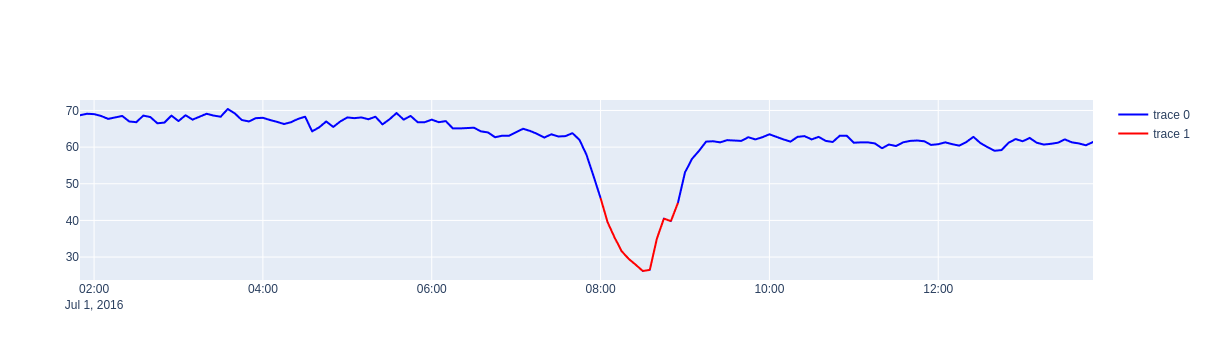

In [16]:
fig = go.Figure()
fig.add_scattergl(x=result["timestamp"], y=result["speed"], line={'color': 'blue'})
fig.add_scattergl(x = result["timestamp"], y = result["speed"].where(result["svm_result"] == 1), line ={'color' : 'red'})
fig.show()

In [17]:
def dr_score(list):
    No_of_congestions_detected=0
    No_of_true_congestions=len(list)
    for x in list:
        result=svm_result(x)
        if result.query('1== svm_result and 1 ==current').shape[0]>1:
            No_of_congestions_detected+=1
    return(No_of_congestions_detected/No_of_true_congestions)
            
print(dr_score(acident_index_test)) 

0.9


In [18]:
def far(list):
    No_of_false_alarms_signals=0
    No_of_non_congestion_instances=0
    for x in list:
        result=svm_result(x)
        No_of_non_congestion_instances+=result.query('0 ==current').shape[0]
        if result.query('1== svm_result and 0 ==current').shape[0]>1:
            No_of_false_alarms_signals+=result.query('1== svm_result and 0 ==current').shape[0]
    return(No_of_false_alarms_signals/No_of_non_congestion_instances)
            
print(far(acident_index_test))

0.03204047217537943


In [19]:
def MTTD(list):
    No_of_congestions_detected=0
    sum_of_time=0
    for x in list:
        result=svm_result(x)
        if result.query('1== svm_result and 1 ==current').shape[0]>1:
            sum_of_time+=(result[(result.svm_result == 1) &(result.current == 1)].iloc[0]["timestamp"]-incident.at[x,'timestamp']).total_seconds() / 60
            No_of_congestions_detected+=1
    return(sum_of_time/No_of_congestions_detected)        
print(MTTD(acident_index_test))

3.888888888888889
